In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

model_path = "./mlp_model_traced.pt"
test_data_path = "./datasets/simulation_data_cleaned2.csv"

# Load the unseen test dataset
df_test = pd.read_csv(test_data_path)

In [2]:
features = ['slip_ratio', 'angular_velocity', 'linear_speed', 
            'current_brake_torque', 'current_drive_torque', 
            'speed_to_velocity_ratio', 'excess_drive_torque', 'slip_deviation']
targets = ['desired_drive_torque', 'desired_brake_torque']

X_test = df_test[features].values
y_test = df_test[targets].values

scaler = MinMaxScaler()
scaler.fit(df_test[features])
X_test = scaler.transform(X_test)

target_scaler = MinMaxScaler()
target_scaler.fit(df_test[targets])
y_test_scaled = target_scaler.transform(y_test)

c:\Users\gc042\OneDrive\Desktop\GitHub\traction_control\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\gc042\OneDrive\Desktop\GitHub\traction_control\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.jit.load(model_path).to(device)
model.eval()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).cpu().numpy()

y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test_scaled)

mse = mean_squared_error(y_test_original, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 1.8323


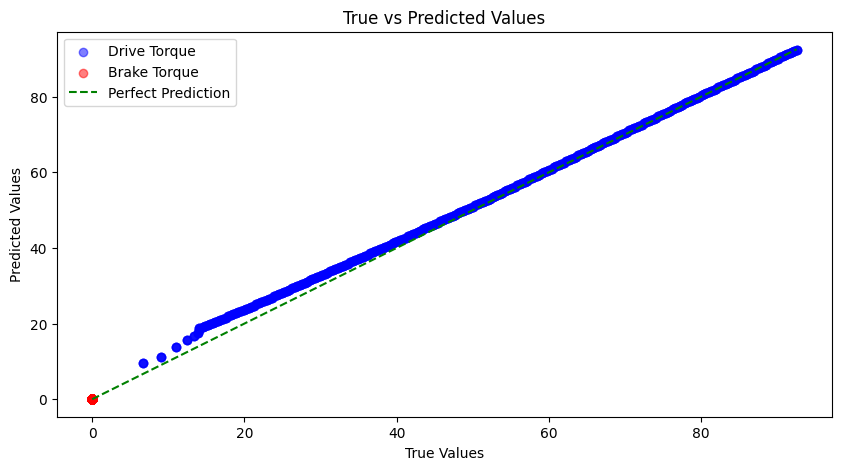

In [4]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test_original[:, 0], y_pred[:, 0], alpha=0.5, label="Drive Torque", color="blue")
plt.scatter(y_test_original[:, 1], y_pred[:, 1], alpha=0.5, label="Brake Torque", color="red")
plt.plot([min(y_test_original.flatten()), max(y_test_original.flatten())], 
         [min(y_test_original.flatten()), max(y_test_original.flatten())], 
         color="green", linestyle="--", label="Perfect Prediction")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.legend()
plt.show()

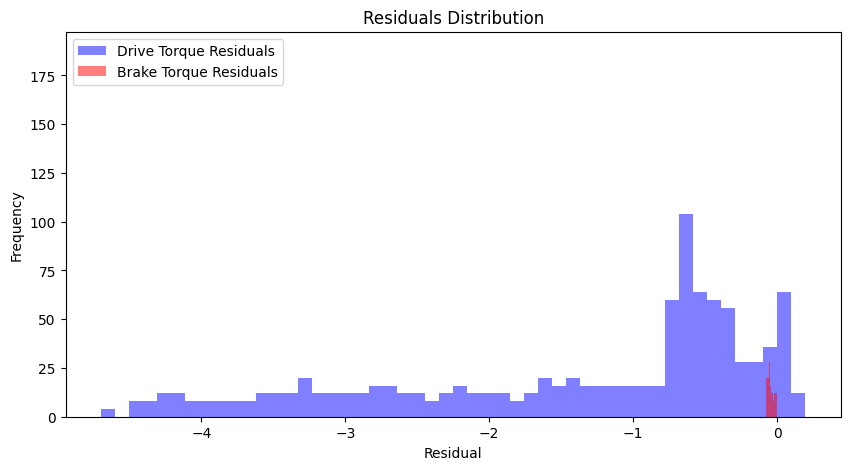

In [5]:
residuals = y_test_original - y_pred
plt.figure(figsize=(10, 5))
plt.hist(residuals[:, 0], bins=50, alpha=0.5, label="Drive Torque Residuals", color="blue")
plt.hist(residuals[:, 1], bins=50, alpha=0.5, label="Brake Torque Residuals", color="red")
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.legend()
plt.show()